<a href="https://colab.research.google.com/github/wlsisl/ESAA_22-2/blob/main/classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 06 XGBoost( eXtra Gradient Boost)

XGBoost : GBM에 기반하고 있지만 GBM의 단점인 느린 수행 시간 및 과적합 규제 부재 등의 문제를 해결하고있다. 특히 병렬 cpu환경에서 병렬 학습이 가능해 기존 gbm보다 빠르게 학습을 완료할 수 있다.

<XGBoost의 장점>
1. 뛰어난 예측 성능
2. GBM대비 빠른 수행 시간
3. 과적합 규제
4. Tree pruning 나무 가지치기 - GBM은 분할 시 부정 손실이 발생하면 분할을 더이상 수행하지 않지만 이 방식도 지나치게 많은 분할을 발생할 수 있다. 그래서 이것을 통해 더 이상 긍정 이득이 없는 분할을 가지치기 해서 분하 ㄹ수를 더 줄임
5. 자체 내장된 교차 검증
6. 결손값 자체 처리

파이썬 패키지명 : xgboost
XGBoost 고유의 프레임워크를  파이썬 언어 기반에서 구현한 것으로 별도의 API기반이었다. 사이킷런 프레임워크를 기반으로 한 것이 아니기에 사이킷런의 fit(), predict())메서드와 같은 고유의 아키텍처가 적용될 수 없으며, 다양한 유틸리티와 함께 사용될 수 없었다. 
-> 래퍼 클래스를 제공하여 사이킷런과 연동할 수 있게 함. 

* 사이킷런의 래퍼 클래서 : XGBClassifier , XGBRegressor  를 이용한다.

* 독자적인 XGBoost 프레임 워크 기반과 사이킷런과 연동되는 모듈, 이 두가지를 구분하고 사용시 주의해야함.



In [3]:
import xgboost as xgb
from xgboost import XGBClassifier

### 파이썬 래퍼 XGBoost 하이퍼 파라미터
- GBM과 유사한 하이퍼 파라미터 동일 + 조기중단 + 과적합 규제 위한 파라미터

여기서 아까 언급하였던 파이썬 본래의 XGBoost모듈과 사이킷런의 XGBoost모듈의 일부 하이퍼 파라미터가 다르다.( 같은기능이지만)

1. 파이썬 래퍼의 XGBoost 하이퍼 파라미터 종류
 * 일반 파라미터 : 일반적으로 실행시 스레드의 개수나 silent 모드 등의 선택을 위한 파라미터로서 디폴트 파라미터 값을 바꾸는 경우는 거의 없다.

    1) booster : gbtree 또는 gblinear선택. 디폴트는 전자.

    2) silent: 디폴트는 0, 출력 메시지를 나타내고 싶지 않을 경우

    3) nthread: cpu의 실행 스레드 개수를 조정하며, 디폴트는 cpu의 전체 스레드를 다 사용하는 것. 멀티 코어/스레드 cpu시스템에서 전체 cpu를 사용하지 않고 일부 cpu만 사용해 ml애플리케이션을 구동하는 경우 변경함

 * 부스터 파라미터 : 트리 최적화, 부스팅, regularization등과 관련 파라미터 등을 지칭한다.

    1) eta : GBM의 학습률과 같음. 0에서 1사이의 값을 지정하며 부스팅 스텝을 반복적으로 수행할 때 업데이트 되는 학습률 값. 디폴트는 0.1이며 보통 0.01~0.2사이 값을 선호

    2) num_boost_rounds: GBM의 n_estimators와 같은 파라미터

    3) min_child_weight[default=1] : 트리에서 추가적으로 가지를 나눌지를 결정하기 위해 필요하 ㄴ데이터들의 weight 총합. ( 이 값이 클수록 분할을 자제한다. 즉 과적합을 조절함)

    4) gamma : 트리의 리프 노드를 추가적으로 나눌지를 결정할 최소 손실 감소 값이다. 해당 값보다 큰 손실이 감소된 경우에 리프 노드를 분리한다. 값이 클수록 과적합 감소 효과가 있다. 

    5) max_depth[default=6] : 트리 기반 알고리즘의 max_depth와 같다. 0을 지정하면 깊이에 제한이 없다. 이 값이 높으면 특정 피처 조건에 특화되어 룰 조건이 만들어지므로 과적합 가능성이 높아지며 보통 3~10 사이 값을 적용한다.

    6) sub_sample[default=1] : GBM의 subsample과 동일하다. 트리가 커져서 과적합되느 ㄴ것을 제어하기 위해 데이터를 샘플링하는 비율을 지정한다. 

    7) colsample_bytree[default=1] : GBM의 max_features와 유사. 트리 생성에 필요한 피처를 임의로 샘플링 하는 데 사용. 매우 많은 피처(칼럼)가 있는 경우 과적합을 조정하는데 적용

    8) lambda[default=1] : L2 Regularization적용값임. 피처 개수가 많을 경우 적용을 검토하며 값이 클수록 과적합 감소효과가 있음.

    9) alpha[default=0] : L1 Regularization적용값. 피처 개수가 많을 경우 적용을 검토하며 값이 클수록 과적합 감소 효과가 있다.

    10) scale_pos_weight[default=1] : 특정 값으로 치우친 비대칭한 클래스로 구성된 데이터 세트의 균형을 유지하기 위한 파라미터  

 * 학습 태스크 파라미터: 학습 수행 시의 객체 함수, 평가를 위한 지표 등을 설정하느 ㄴ파라미터이다. 

    1) objective: 최솟값을 가져야할 손실 함수를 정의 많은 유형의 손실 함수를 사용할 수 있는데 이진분류인지 다중 분류인지에 따라 달라짐.

    2) binary:logistic:이진 분류일 때 적용 

    3) multi:softmax: 다중 분류일 때 적용. num_class를 지정해야함(레이블 클래스 개수)
    
    4) multi:softprob: 위와 유사하나 개별 레이블 클래스의 해당되는 예측 확률을 반환한다.

    5) eval_metric:검증에 사용되는 함수를 정의한다. 
    
    기본값은 회귀인 경우: rmse, 분류일 경우: error
    
      - mae , logloss, merror, mlogloss, auc 등이 있음.

  
<과적합 문제가 심각하다면 해결책>
* eta값을 낮춘다. num_round는 반대로 높여줘야한다.
* max_depth 값을 낮춘다.
* min_child_weight값을 높인다.
* gamma 값을 높인다.
* subsample과 colsample_bytree를 조정하는 것도 트리가 너무 복잡하게 생성되는 것을 막아 과적합 문제에 도움이 된다.

XGBoost자체적으로 교차검증/ 성능 평가/피처 중요도 등 시각화 기능을 가지고 있다. 




In [4]:
import xgboost

print(xgboost.__version__)

0.90


### 파이썬 래퍼 XGBoost적용 : 위스콘신 유방암 예측

위스콘신 유방암 데이터 세트를 활용하여 파이썬 래퍼 XGBoost API의 사용법을 살표보자.

데이터 설명 : 종양의 크기, 모양 등의 다양한 속성값을 기반으로 악성 종양인지 양성 종양인지를 분류한 데이터 세트이다. 

해당 데이터 세트에 기반해 종양의 다양한 피처에 따라 악성종양인지 일반 양성종양인지를 xgboost를 이용해 예측해보자.

In [5]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label=dataset.target
cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']=y_label
cancer_df.head(3)



,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


-> 종양의 크기와 모양에 관련된 많은 속성이 숫자형 값으로 돼있다. 타깃 레이블 값의 종류는 악성인 'malignant'가 0 , 양성인 'benign'이 1로 돼있다. 

In [6]:
#값의 분포보기
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [7]:
#전체 데이터 중 80%는 학습용데이터 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features,y_label,test_size=0.2, random_state=156 )

print(X_train.shape,X_test.shape)

(455, 30) (114, 30)


-> 파이썬 래퍼 XGBoost는 사이킷런과 차이가 여러가지 있지만 눈에 띄는 차이는 학습용과 테스트용 데이터 세트를 위해 별도의 객체인 DMatrix를 생성한다는 점이다. 주요 파라미터는 data(피처 데이터 세트), label( 분류의 경우 레이블 데이터 세트, 회귀의 경우 숫자형 종솟값 데이터 세트)



In [8]:
# 넘파이 형태의 학습데이터 세트와 테스트 데이터 세트를 DMatrix로 변환하는 예제  
dtrain = xgb.DMatrix(data=X_train, label = y_train)
dtest= xgb.DMatrix(data=X_train, label = y_train)

파이썬 래퍼 XGBoost모듈인 xgboost를 이용해 학습을 수행하기 전 먼저 XGBoost의 하이퍼 파라미터를 설정한다. 

* max_depth(트리 최대 깊이)는 3.
* 학습률 eta는 0.1
* 예제 데이터가 0또는 1 이진 분류이므로 목적함수(objective)는 이진 로지스틱(binary:logistic)
* 오류 함수의 평가 성능지표는 logloss
* num_rounds(부스팅 반복 횟수)는 400회.

In [9]:
params = { 'max_depth':3, 'eta':0.1, 'objective':'binary:logistic', 'eval_metric':'logloss', 'early_stoppings':100}
num_rounds = 400

이제 모델을 학습시켜보자. 파이썬 래퍼 XGBoost는 하이퍼 파라미터를 xgboost모듈의 train()함수에 파라미터로 전달한다. (사이킷런의 경우는 estimator의 생성자를 하이퍼 파라미터로 전달하는데 반해 차이가 있음)

조기중단: xgboost의 trian()함수에 early_stopping_rounds 파라미터를 입력하여 설정
이때 반드시 eval_set과 eval_metric이 함께 설정 돼야 한다. 

* eval_set : 성능 평가를 수행할 평가용 데이터 세트를 설정
* eval_metric: 평가 세트에 적용할 성능 평가 방법. 분류일 경우 주로 error, logloss를 적용

In [10]:
#train 데이터 세트는 'train', evaluation(test)데이터 세트는 'eval'로 명기
wlist=[(dtrain, 'train'),(dtest, 'eval')]
#하이퍼 파라미터와 early stopping 파라미터를 train()함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round= num_rounds, early_stopping_rounds=100, evals=wlist)

[0]	train-logloss:0.609688	eval-logloss:0.609688
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 100 rounds.
[1]	train-logloss:0.540803	eval-logloss:0.540803
[2]	train-logloss:0.483753	eval-logloss:0.483753
[3]	train-logloss:0.434457	eval-logloss:0.434457
[4]	train-logloss:0.39055	eval-logloss:0.39055
[5]	train-logloss:0.354146	eval-logloss:0.354146
[6]	train-logloss:0.321222	eval-logloss:0.321222
[7]	train-logloss:0.292593	eval-logloss:0.292593
[8]	train-logloss:0.267467	eval-logloss:0.267467
[9]	train-logloss:0.245153	eval-logloss:0.245153
[10]	train-logloss:0.225694	eval-logloss:0.225694
[11]	train-logloss:0.207938	eval-logloss:0.207938
[12]	train-logloss:0.192184	eval-logloss:0.192184
[13]	train-logloss:0.177916	eval-logloss:0.177916
[14]	train-logloss:0.165222	eval-logloss:0.165222
[15]	train-logloss:0.153622	eval-logloss:0.153622
[16]	train-logloss:0.14333	eval-logloss:0.14333
[17]	train-log

-> train으로 학습을 수행하면 반복 시 train-error 와 eval-logloss가 지속적으로 감소한다. 

이제 모델 학습이 완료 됐으면, 이를 이용해 테스트 데이터 세트에 예측을 수행해보자.

**차이점) xgboost의 predict()는 예측 결괏값이 아니라 예측 결과를 추정할 수 있는 확률 값을 반환한다.**



In [11]:
pred_probs = xgb_model.predict(dtest)
print('predict()수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10],3))

#예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds= [1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:0])

predict()수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.007 0.998 1.    0.998 0.978 0.023 1.    0.001 0.001 0.998]
예측값 10개만 표시: []


In [12]:
# 테스트 실제 레이블 값을 가지는 y_test와 예측 레이블인 preds를 인자로 입력한다. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

#get_clf_eval 함수 생성
def get_clf_eval(y_test, pred=None, pred_proba=None):
  confusion=confusion_matrix(y_test, pred)
  accuracy=accuracy_score(y_test, pred)
  precision=precision_score(y_test, pred)
  recall=recall_score(y_test, pred)
  f1=f1_score(y_test, pred)
  roc_auc=roc_auc_score(y_test, pred_proba)
  print('오차 행렬')
  print(confusion)
  print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, \
   F1: {3:.4f}, roc_auc:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

get_clf_eval(y_test, preds, pred_probs)

ValueError: ignored

이제 xgboost패키지에 내장된 시각화 기능을 수행해보자. 
plot_importance() API :피처의 중요도를 막대그래프 형식으로 나타냄. 기본 평가 지표로 f1스코어를 기반으로 해 각 피처의 중요도를 나타낸다. 

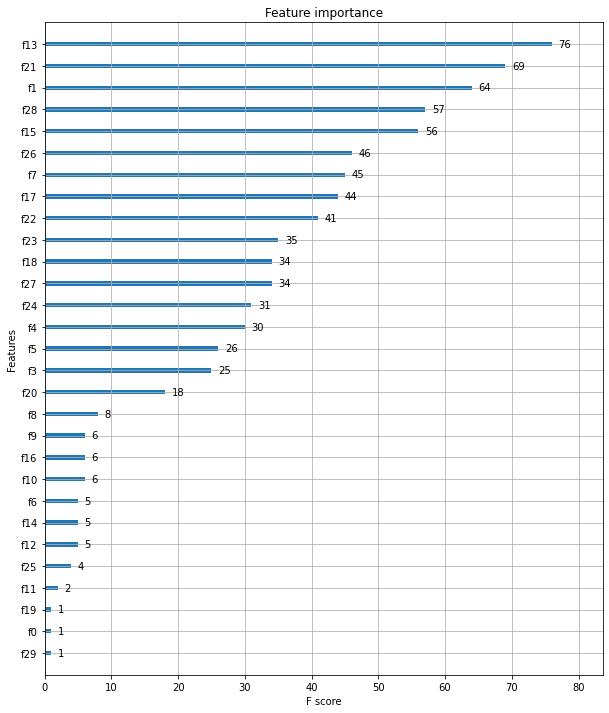

In [13]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax= plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

결정 트리에서 보여준 트리 기반 규칙 구조도 xgboost에서 시각화 할 수 있다. 

* to_graphviz() API를 이용하면 주피터 노트북에 바로 규칙 트리 구조를 그릴 수 있다. 

* cv() API : 데이터 세트에 대한 교차검증 수행후 최적 파라미터를 구할 수 있는 방법

In [14]:
xgboost.cv(params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None, \
           metrics=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None, fpreproc=None, as_pandas=True,\
           verbose_eval=None, show_stdv=True, seed=0, callbacks=None, shuffle=True)

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.610037,0.000064,0.617447,0.004961
1,0.541817,0.000202,0.555140,0.008989
2,0.483717,0.000955,0.503529,0.012238
3,0.434676,0.001311,0.459869,0.015795
4,0.392310,0.001686,0.423058,0.016788
5,0.355129,0.001390,0.391187,0.019785
6,0.322530,0.001908,0.361119,0.019378
7,0.294159,0.001618,0.337140,0.021086
8,0.269083,0.002068,0.314903,0.019972
9,0.246208,0.001940,0.295012,0.019237


* params : 부스터 파라미터
* dtrain : 학습데이터
* num_boost_round : 부스팅 반복 횟수
* nfold : cv폴드 개수.
* stratified : cv 수행 시 층화 표본 추출 수행 여부
* metrics : cv수행시 모니터링할 성능 평가 지표
* early_stopping_rounds : 조기 중단을 활성화시킴. 반복 횟수 지정.



---

### 사이킷런 래퍼 XGBoost의 개요 및 적용

사이킷런의 기본 estimator을 그대로 상속해 만들었기 대문에 다른 estimator와 동일하게 fit()과 predict()만으로 학습과 예측이 가능하고 gridsearchcv, pipeline 등 사이킷런읟 ㅏ른 유틸리티를 그대로 사용할 수 있기 때문에 기존의 다른 머신러닝 알고리즘으로 만들어놓은 프로그램이 있더라도 알고리즘 클래스만 xgboost 래퍼 클래스로 바꾸면 사용 가능하다.

분류를 위한 래퍼클래스 : XGBClassifier

회귀를 위한 래퍼 클래스 : XGBRegressor

<파이썬 래퍼 xgboost와 파라미터 차이>
* eta -> learning_rate
* sub_sample -> subsample
* lambda -> reg_lambda
* alpha -> reg_alpha
* n_estimators가 num_boost_round보다 우선순위


In [15]:
#사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba= xgb_wrapper.predict_proba(X_test)[:,1]

In [16]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, roc_auc:0.9951


-> 파이썬 래퍼 xgboost와 동일한 평가 결과가 나옴.

여기서도 조기 중단을 수행할 수 있는데 

early_stopping_rounds : 평가 지표가 향상될 수 있는 반복 횟수 정의

eval_metric : 조기 중단을 위한 평가 지표

eval_set : 성능 평가를 수행할 데이터세트

* 성능 평가를 수행할 데이터 세트는 학습 데이터가 아니라 별도의 데이터 세트여야 한다. 데스트 데이터 세트는 학습 시에는 완전히 알려지지 않은 데이터 세트를 사용해야 한다. 평가에 테스트 데이터 세트를 사용하면 학습 시에 미리 참고가 되어 과적합할 수 있기 때문.

In [17]:
#but 이 예제는 데이터 세트의 크기가 작아 테스트 데이터를 평가용으로 사용함.

from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", eval_set = evals, verbose=True)

ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba= xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

-> 400으로 설정해도 311번 반복한 후 학습을 완료했다.

그 이유는 211번 반복시 logloss가 0.085593이고 311번 반복시 logloss가 0.085948인데, 211번에서 311번까지 early_stopping_rounds=100으로 지정한 100번의 반복동안 성능 평가 지수가 향상되지 않았기 때문에 반복하지 않고 중단함.

In [18]:
#조기 중단으로 학습된 XGBClassifier의 예측 성능
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, roc_auc:0.9954


-> 조기 중단값을 너무 급격하게 줄이면 예측 성능이 저하될 우려가 크다. 즉  early_stopping_rounds를 너무 적게 설정하면 그 반복수 이후로 향상되는 값이 나올 수 있기 때문에 예측 성능이 나빠질 수 있다.

In [19]:
# early_stopping_rounds를 10으로 설정하고 재학습.

xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set = evals, verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba= xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912


-> 62번 반복까지만 수행된 후 학습이 종료됐는데 이때 예측 결과 정확도는 early_stopping_rounds가 100일때보다 낮다.



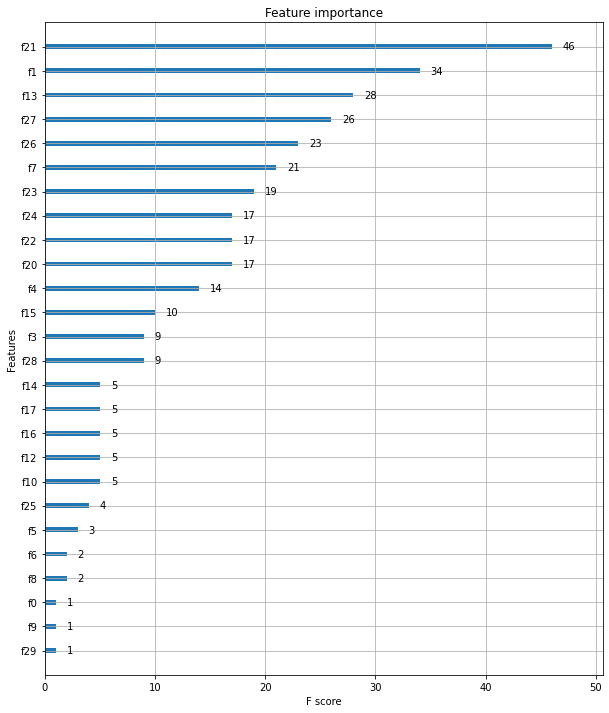

In [20]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax= plt.subplots(figsize=(10,12))
#사이킷런 Wrapper 클래스를 입력해도 무방.
plot_importance(xgb_wrapper, ax=ax)



---
### 07 LightGBM
* 부스팅 계열 알고리즘에서 각광 받고 있다.
* XGBoost보다 학습에 걸리는 시간이 훨씬 적고 메모리 사용량도 적다. 
* 단점은 적은 데이터 세트에 적용할 경우 과적합이 발생하기 쉽다. (일반적으로 만건 이하의 데이터 세트정도가 적은 데이터 세트)
* GBM계열의 트리 분할 방법과 다르게 **리프 중심 트리 분할 방식을 사용함.**
* 최대 손실값을 가지는 리프 노드를 지속적으로 분할해 생성된 규칙 트리는 학습을 반복할수록 결국은 균형 트리 분할 방식보다 예측 오류 손실을 최소화 할 수 있다.

정리하면, 
1. 더빠른 학습과 예측 수행시간.

2. 더 작은 메모리 사용량

3. 카테고리형 피처의 자동변환과 최적 분할( 원-핫 인코딩 등을 사용하지 않고도 카테고리형 피처를 최적으로 변환하고 이에 따른 노드 분할 수행)

패키지명 : LightGBM
분류를 위한 클랫 : LGBMClassifier
회귀를 위한 클래스: LGBMRegressor



### LightGBM 하이퍼 파라미터

* 주요 파라미터
  * num_iterations: 반복수행하려는 트리의 개수를 지정 크게 지정할수록 에측 성능이 높아질 수 있으나, 너무 크면 과적합으로 성능 저하. n_estimator와 같음.
  * learning_rate: 0에서 1사이의 값을 지정해 부스팅 스텝을 반복적으로 수행할 때 업데이트되는 학습률 값. 일반적으로 n_estimator를 크게 하고, learning_rate를 작게 해서 예측 성능을 향상시킬 수 있으나, 과적합 이슈와 학습 시간이 길어지는 영향이 있을 수도 있음.
  * max_depth: 트리기반 알고리즘의 max_depth와 같음.
  * min_data_in_deaf [default=20]: 최종 결정 크래스인 리프 노드가 되기 위해서 최소한으로 필요한 레코드 수이며, 과적합을 제어하기 위한 파라미터. 사이킷런 래퍼 LightGBM 클래스인 LightGBMClassifier에서는 min_child_samples 파라미터로 이름이 변경.
  * num_leaves: 하나의 트리가 가질 수 있는 최대 리프 개수
  * boosting: 부스팅 트리를 생성하는 알고리즘 기술
     * gbdt: 일반적인 그래디언트 부스팅 결정 트리
     * rf: 랜덤 포레스트
  * bagging_fraction [default=1.0]:트리가 커져 과적합 되는 것을 제어하기 위해 데이터를 샘플링하는 비율 지정
  * feature_fraction [default=1.0]: 개별 트리를 학습할 때마다 무작위로 선택하는 피처의 비율. 과적합을 막기 위해 사용됨
  * lambda_l2: 앞서와 동일
  * labmda_l1: 앞서와 동일

* Learning Task파라미터
  * objective: 최솟값을 가져야 할 손실함수를 정의.회귀, 다중 클래스 분류, 이진 분류인지에 따라서 손실함수가 지정됨.

### 하이퍼 파라미터 튜닝 방안
num_leaves의 개수를 중심으로 min_child_sampels(min_data_in_leaf), max_depth를 함께 조정하면서 모델의 복잡도를 줄이는 것이 기본 튜닝 방안

  * num_leaves: 개별 트리가 가질 수 있는 최대 리프의 개수, LightGBM 모델의 복잡도를 제어하는 주요 파라미터. 일반적으로 num_leaves의 개수를 높이면 정확도가 높아지지만, 반대로 트리의 깊이가 깊어지고 모델이 복잡도가 커져 과적합 영향도가 커진다.
  * min_data_in_leaf: 사이킷런 래퍼 클래스에서는 min_child_samples. 과적합을 개선하기 위한 중요 파라미터. num_leaves와 학습 데이터의 크기에 따라 달라지지만, 보통 큰 값으로 설정하면 트리가 깊어지는 것을 방지한다.
  * max_depth는 명시적으로 깊이의 크기를 제한한다. num_leaves,min_data_in_leaf와 결합해 과적합을 개선하는 데 사용.

learning_rate를 작게 하면서 n_estimators를 크게 하는 것은 부스팅 계열 튜닝에서 가장 기본적인 튜닝 방안이므로 이를 적용하는 것도 좋다.
n_estimators를 너무 크게 하는 것은 과적합으로 오히려 성능이 저하될 수 있음을 유념해야 한다.

이밖에 과적합을 제어하기 위해서 reg_lambda, reg_alpha와 같은 regularization을 적용하거나 학습 데이터에 사용할 피처의 개수나 데이터 샘플링 레코드 개수를 줄이기 위해 colsample_bytree, subsample 파라미터를 적용할 수 있다.

### 파이썬 래퍼 LightGBM과 사이킷런 래퍼 XGBoost, LightGBM 하이퍼 파라미터 비교

LightGBM은 사이킷런과 호환하기 위해 분류를 위한 LGBMClassifier와 회귀를 위한 LGBMRegressor 클래스를 래퍼 클래스로 생성
사이킷런 래퍼 클래스를 제공한 XGBoost는 사이킷런 하이퍼 명명 규칙에 따라 자신의 하이퍼 파라미터를 변경

LightGBM은 XGBoost와 많은 유사한 기능이 있었기에 사이킷런 LightGBM의 하이퍼 파라미터를 사이킷런 XGboost에 맞춰서 변경. 이 때문에 사이킷런 래퍼 LightGBM 클래스와 사이킷런 래퍼 XGBoost 클래스는 많은 하이퍼 파라미터가 똑같다.


---


### LightGBM 적용 - 위스콘신 유방암 예측

In [21]:
# LightGBM의 파이썬 패키지인 lightgbm 에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size=0.2, random_state=156)

# 앞서 XGBoost와 동일하게 n_estimators는 400 설정
lgbm_wrapper = LGBMClassifier(n_estimators=400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능. 
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss",
                 eval_set=evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[1]	valid_0's binary_logloss: 0.565079	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's binary_logloss: 0.507451	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355846	valid_0's binary_logloss: 0.355846
[7]	valid_0's binary_logloss: 0.330897	valid_0's binary_logloss: 0.330897
[8]	valid_0's binary_logloss: 0.306923	valid_0's binary_logloss: 0.306923
[9]	valid_0's binary_logloss: 0.28776	valid_0's binary_logloss: 0.28776
[10]	valid_0's binary_logloss: 0.26917	valid_0's binary_logloss: 0.26917
[11]	valid_0's binary_logloss: 0.250954	valid_0's binary_logloss: 0.250954
[12]	valid_0's binary_logloss: 0.23847	valid_0's binary_logloss: 0.23847
[13]	valid_0's binary_logloss: 0.225865	valid_0's bi

In [22]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[33  4]
 [ 2 75]]
정확도: 0.9474, 정밀도: 0.9494, 재현율: 0.9740,    F1: 0.9615, roc_auc:0.9926


-> 정확도가 약 94.74%이다. 앞 예제의 XGBoost인 경우보다는 작지만 워낙 데이터 세트 크기가 작아 성능 비교는 큰 의미가 없다. 


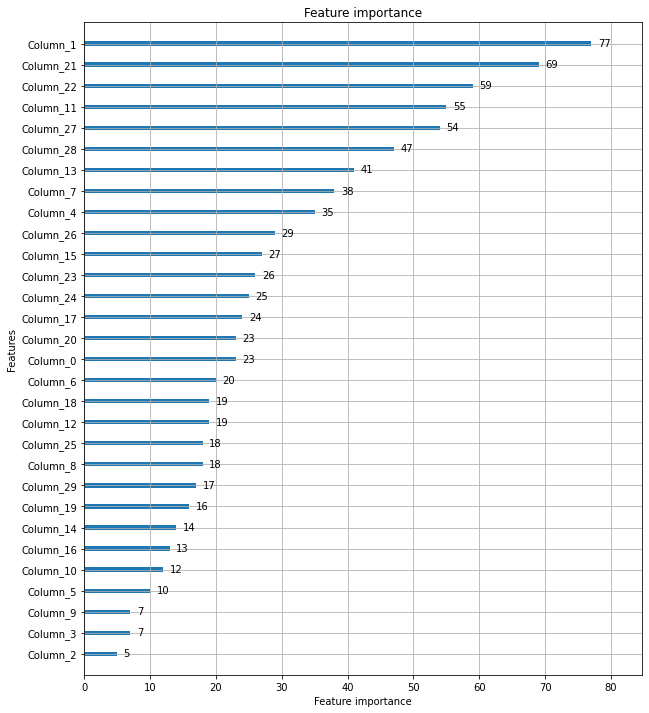

In [23]:
#피처 중요도 시각화 제공
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(lgbm_wrapper, ax=ax)

## 10 스태킹 앙상블

 스태킹(Staking)은 개별적인 여러 알고리즘을 서로 결합해 예측 결과를 도출한다는 점에서 앞에 소개한 배깅(Bagging) 및 부스팅(Boosting)과 공통점을 가지고 있다.

가장 큰 차이점은 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행한다는 것이다. 즉, 개별 알고리즘의 예측 결과 데이터 세트를 최종적인 메타 데이터 세트로 만들의 별도의 ML 알고리즘으로 최종 학습을 수행하고 테스트 데이터를 기반으로 다시 최종 예측을 수행하는 방식이다.

메타 모델: 개별 모델의 예측된 데이터 세트를 다시 기반으로 하여 학습하고 예측하는 방식

------------------
스태킹 모델은 두 종류의 모델이 필요하다.

1. 개별적인 기반 모델

2. 최종 메타 모델

핵심: 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합해 최종 메타 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것.

스태킹을 적용할 때는 많은 개별 모델이 필요함: 2~3개의 개별 모델만을 결합해서는 쉽게 예측 성능을 향상시킬 수 없으며, 스태킹을 적용한다고 해서 반드시 성능 향상이 되리라는 보장도 없음. 일반적으로 성능이 비슷한 모델을 결합해 좀 더 나은 성능 향상을 도출하기 위해 적용된다.

즉, 여러 개의 모델에 대한 예측값을 합한 후, 스태킹 형태로 쌓은 뒤 이에 대한 예측을 다시 수행하는 것



---
### 기본 스태킹 모델


In [24]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=0)

스태킹에 사용될 머신러닝 알고리즘 클래스 생성

개별 모델은 KNN, 랜덤 포레스트, 결정트리, 에이다부스트이며, 이들 모델의 예측 결과를 합한 데이터 세트로 학습/예측하는 최종 모델은 로지스틱 회귀이다.

In [25]:
# 개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final = LogisticRegression(C=10)

In [26]:
# 개별 모델들을 학습.
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

개별 모델의 예측 데이터 세트를 반환하고 각 모델의 예측 정확도살펴보자.

In [28]:
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에어다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9035
에어다부스트 정확도: 0.9561


개별 알고리즘으로부터 예측된 예측값을 칼럼 레벨로 옆으로 붙여서 피처 값으로 만들어, 최종 메타 모델인 로지스틱 회귀에서 학습 데이터로 다시 사용한다.

반환된 예측 데이터 세트는 1차원 형태의 ndarray이므로 먼저 반환된 예측 결과를 행 형태로 붙인 뒤, 넘파이의 transpose()를 이용해 행과 열 위치를 바꾼 ndarray로 변환하면 된다.

In [29]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


이렇게 예측 데이터로 생성된 데이터 세트를 기반으로 최종 메타 모델인 로지스틱 회귀를 학습하고 예측 정확도를 측정한다.

In [30]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도: 0.9649


-> 개별 모델의 예측 데이터를 스태킹으로 재구성해 최종 메타 모델에서 학습하고 예측한 결과, 정확도가 97.37%로 개별 모델 정확도보다 향상됨.

-------------
이제 과적합 개선하기 위한 cv세트 기반의 스태킹 모델을 살펴보자.

### CV세트 기반의 스태킹


이 모델은 과적합을 개선하기 위해 최종 메타 모델을 위한 데이터 세트를 만들 때 교차 검증 기반으로 예측된 결과 데이터 세트를 이용한다. 

개별 모델들이 각각 교차 검증으로 메타 모델을 위한 학습용 스태킹 데이터 생성과 예측을 위한 테스트용 스태킹 데이터를 생성한 뒤 이를 기반으로 메타 모델이 학습과 예측을 수행한다. 

* 스텝1: 각 모델별로 원본 학습/테스트 데이터를 예측한 결과 값을 기반으로 메타 모델을 위한 학습용/테스트용 데이터를 생성한다.

* 스텝2: 스텝1에서 개별 모델들이 생성한 학습용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 학습할 최종 학습용 데이터 세트를 생성. 마찬가지로 각 모델들이 생성한 테스트용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 예측할 최종 테스트 데이터 세트를 생성. 메타 모델은 최종적으로 생성된 학습 데이터 세트와 원본 학습 데이터의 레이블 데이터를 기반으로 학습한 뒤, 최종적으로 생성된 테스트 데이터 세트를 예측하고, 원본 테스트 데이터의 레이블 데이터를 기반으로 평가한다.



---

### step 1구현

In [34]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds) :
  # 지정된 n_folds값으로 KFold 생성
  kf = KFold(n_splits=n_folds, shuffle=False)
  # 추후에 메타 모델이 사용할 학습 데이터 반환을 위해 넘파이 배열 초기화
  train_fold_pred = np.zeros((X_train_n.shape[0], 1))
  test_pred = np.zeros((X_test_n.shape[0], n_folds))
  print(model.__class__.__name__, 'model 시작')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    # 입력된 학습 데이터에서 기반모델이 학습/예측할 폴드 데이터 세트 추출
    print('\t 폴드 세트: ', folder_counter, '시작')
    X_tr = X_train_n[train_index]
    y_tr = y_train_n[train_index]
    X_te = X_train_n[valid_index]

    # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
    model.fit(X_tr, y_tr)
    # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
    train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
    # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
    test_pred[:, folder_counter] = model.predict(X_test_n)

  # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
  test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

  # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
  return train_fold_pred, test_pred_mean

이제 여러 개의 분류 모델별로 stack_base_model()함수를 수행한다.

In [33]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
RandomForestClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
DecisionTreeClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
AdaBoostClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작


### step 2구현
 앞의 예제에서 get_stacking_base_datasets()호출로 반환된 각 모델별 학습 데이터와 테스트데이터를 합치기만 하면 된다.

 * concatenate() : 여러 개의 넘파이 배열을 칼럼 또는 로우 레벨로 합쳐주는 기능 제공

In [35]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:', X_train.shape, '원본 테스트 피처 Shape:', X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:', Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


Stack_final_X_train: 메타 모델이 학습할 학습용 피처 데이터 세트

Stack_final_X_test: 메타 모델이 예측할 테스트용 피처 데이터 세트

스태킹 학습 피처 데이터는 원본 학습 피처 데이터와 로우 크기는 같으며, 4개의 개별 모델 예측값을 합친 것이므로, 칼럼 크기는 4


---



이제 최종 메타 모델인 로지스틱 회귀를 스태킹된 학습용 피처 데이터 세트와 원본 학습 레이블 데이터로 학습한 후, 스태킹된 테스트 데이터 세트로 예측하고, 예측 결과를 원본 테스트 레이블 데이터와 비교해 정확도 측정해보자. 

In [36]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737


### 정리

1. 앙상블 기법 : 결정 트리 기반의 다수의 약한 학습기를 결합해 변동성을 줄여 예측 오류를 줄이고 성능을 개선하고 있다.

2. 배깅: 학습 데이터를 중복을 허용하면서 다수의 세트로 샘플링하여 이를 다수의 약한 학습기가 학습한 뒤 최종 결과를 결합해 예측 하는 방식
   - 랜덤 포레스트 

3. 부스팅: 학습기들이 순차적으로 학습을 진행하면서 예측이 ㅊ틀린 데이터에 대해서는 가중치를 부여해 다음번 학습기가 학습할 때에는 이전에 예측이 틀린 데이터에 대해서는 보다 높은 정확도로 예측할 수 있도록 함
   - XGBoost, LightGBM

4. 스태킹 : 여러 개의 개별 모델들이 생성한 예측 데이터를 기반으로 최종 메타 모델이 학습할 별도의 학습 데이터 세트와 예측할 테스트 데이터 세트를 재 생성하는 기법